## Answering Business Questions Using SQL

In this project, we're going to practice using our SQL skills to answer business questions. We'll be working with a modified version of a database called Chinook. The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

The Chinook database contains information about the artists, songs, and albums from the music shop, as well as information on the shop's employees, customers, and the customers purchases. This information is contained in eleven tables. Like with our Factbook database, a schema diagram will help us understand the available columns and the structure of the data. Here's a schema diagram for the Chinook database:
![](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg)

## Creating Helper Functions

Previously, we used the sqlite3.connect() function to create a connection object, and passed that to the pandas.read_sql_query() function. In this project, we'll use a similar approach, with two important changes:

   + We'll create some helper functions in python to save some time.
   + We'll use a context manager to handle the connection to the SQLite database.

Context managers make our life easy by taking care of opening and closing the connection to the database, as well as making sure we don't accidentally make changes to the database if one of our queries has an error.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#Create a function that takes a SQL query and returns pandas dataframes of that query
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

#Create a function that takes a SQL command and executes it using the sqlite module
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        #Tell SQLite to autocommit any changes
        conn.isolation_level = None
        conn.execute(c)


In [2]:
#Create a function that calls the run_query() function to return a list of all tables and views in the database.
def show_tables():
    q = '''
        SELECT 
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table", "view");
        '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name          | Genre   |
|----------------------|---------|
| Regal                | Hip-Hop |
| Red Tone             | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites       | Blues   |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

We'll need to write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.

In [3]:
q = '''
    WITH usa_purchases AS
    (SELECT 
         i.invoice_id,
         i.billing_country country,
         il.track_id,
         il.quantity,
         g.name
     FROM invoice i
     INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
     INNER JOIN track t ON t.track_id = il.track_id
     INNER JOIN genre g ON g.genre_id = t.genre_id
     WHERE i.billing_country = "USA")

    SELECT 
        name genre,
        SUM(quantity) track_sold,
        CAST(SUM(quantity) as Float)/CAST((SELECT SUM(quantity) FROM usa_purchases) as Float) percentage
    FROM usa_purchases
    GROUP BY 1
    ORDER BY 3 DESC
    LIMIT 10;
    '''
run_query(q)

,genre,track_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


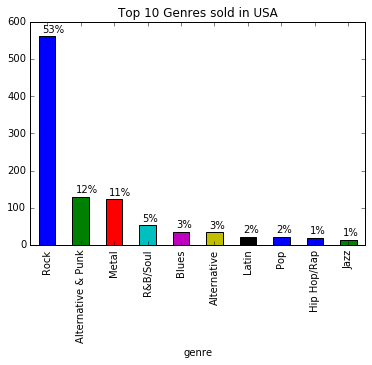

In [4]:
genre_sold_result = run_query(q)
genre_sold_result.set_index("genre", inplace = True, drop = True)
genre_sold_result["track_sold"].plot.bar()
plt.title("Top 10 Genres sold in USA")
for i, label in enumerate(list(genre_sold_result.index)):
    score = genre_sold_result.loc[label, "track_sold"]
    label = (genre_sold_result.loc[label, "percentage"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (i - 0.15, score + 10))
plt.show()

According to our results, the most popular tracks sold in USA is Rock genre, which are about half of the total amount. Among the four album options, we recommend adding Red Tone(Punk), Slim Jim Bites(Blues) and Meteor and the Girls(Pop) to the store.

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. Next, we'll analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others. The number of customers assigned to each employee should be an extra attribute as for their performance.

In [5]:
q = '''
    SELECT DISTINCT(title) FROM employee;
    '''
run_query(q)

,title
0,General Manager
1,Sales Manager
2,Sales Support Agent
3,IT Manager
4,IT Staff


In [6]:
employee_performance = '''
WITH employee_sales_total AS
    (
    SELECT 
        e.employee_id,
        e.first_name,
        e.last_name,
        e.title,
        c.customer_id,
        i.total
    FROM employee e
    INNER JOIN customer c ON e.employee_id = c.support_rep_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    )
    
SELECT 
    first_name || " "|| last_name employee_name,
    title,
    COUNT(customer_id) num_customers_served,
    SUM(total) total_money_sold    
FROM employee_sales_total
GROUP BY 1
ORDER BY 4 DESC;
'''
run_query(employee_performance)


,employee_name,title,num_customers_served,total_money_sold
0,Jane Peacock,Sales Support Agent,212,1731.51
1,Margaret Park,Sales Support Agent,214,1584.00
2,Steve Johnson,Sales Support Agent,188,1393.92


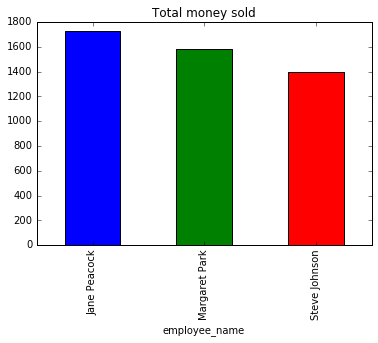

In [7]:
#Create a plot of the dataframe to visualize the result
employee_perf = run_query(employee_performance)
employee_perf.set_index("employee_name", inplace = True, drop = True)
employee_perf["total_money_sold"].plot.bar()
plt.title("Total money sold")

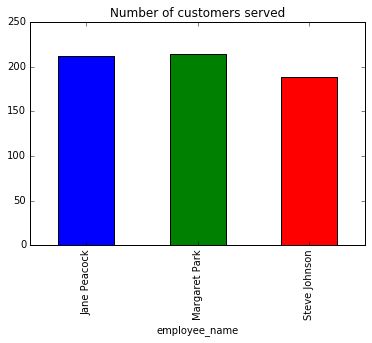

In [8]:
employee_perf["num_customers_served"].plot.bar()
plt.title("Number of customers served")

It shows that Jane Peacock made more contribution to the company's whole sales than the others, while Jane served about the same amount of the customers with the second winner, Margaret Park.

## Analyzing Sales by Country

Our next task is to analyze the sales data for customers from each different country. We will use the country value from the customers table, but not the country from the billing address in the invoice table.

For each country, followings will be calculated:

   + total number of customers
   + total value of sales
   + average value of sales per customer
   + average order value

Because there are a number of countries with only one customer, we need to group these customers as "Other" in our analysis. 

In [9]:
sales_by_country ='''
WITH
    customer_by_country AS
    (SELECT
         country,
         COUNT(DISTINCT customer_id) count_customer
     FROM customer
     GROUP BY country
     ),
    sales_by_country AS
        (SELECT 
             c.customer_id,
             i.invoice_id,
             i.total,
             CASE 
                 WHEN cbc.count_customer = 1 THEN 'Other'
                 ELSE c.country
                 END 
                 AS country
         FROM customer c
         INNER JOIN customer_by_country cbc ON c.country = cbc.country
         INNER JOIN invoice i ON i.customer_id = c.customer_id
         ),
    aggeragate_sales AS
       (
        SELECT
            customer_id,
            COUNT(DISTINCT customer_id) count_customers,
            COUNT(invoice_id) count_transactions, 
            SUM(total) total_value_sold,
            country
         FROM sales_by_country
         GROUP BY country
         ),
     sort_aggeragate_sales AS
         (
          SELECT
              country,
              count_customers,
              total_value_sold,
              total_value_sold/CAST(count_customers as Float) avg_value_per_customer,
              total_value_sold/CAST(count_transactions as Float) avg_order_value,
              CASE
                  WHEN country = 'Other' THEN 0
                  ELSE 1
                  END
                  AS sort
              FROM aggeragate_sales
              GROUP BY 1
              ORDER BY 3 DESC
            )

SELECT 
    country,
    count_customers,
    total_value_sold,
    avg_value_per_customer,
    avg_order_value
FROM sort_aggeragate_sales
ORDER BY sort DESC;

'''

run_query(sales_by_country)       

,country,count_customers,total_value_sold,avg_value_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


## Visualizing Sales by Country

Now that we have our data, we are able to create a series of visualizations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.

When we're working with data that has many dimensions, it can be tempting to try and communicate every dimension in a single plot. This often results in complex and hard to read visualizations. Instead of this, we should create different plots for each dimension.


In [10]:
sale_by_country = run_query(sales_by_country)

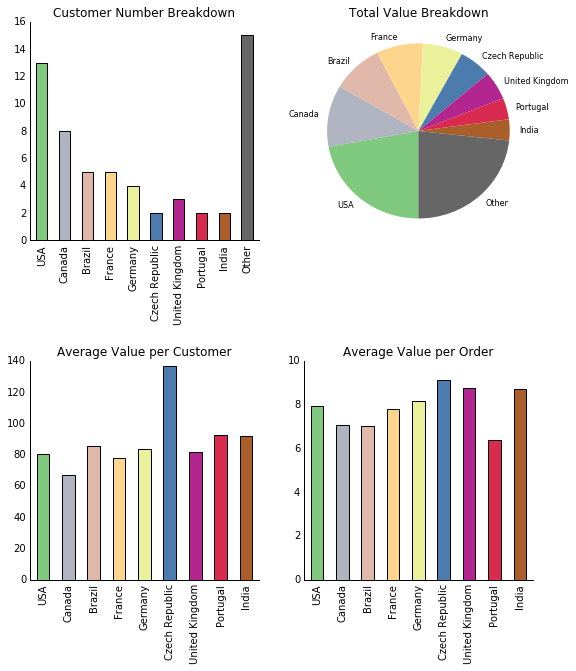

In [11]:
sale_by_country.set_index('country', inplace = True, drop = True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, sale_by_country.shape[0])]
fig, axes = plt.subplots(2, 2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
plt.subplots_adjust(hspace = 0.55)

#top left
customers_breakdown = sale_by_country['count_customers']
customers_breakdown.plot.bar(ax= ax1,
                             color = colors, 
                             title = 'Customer Number Breakdown')
ax1.set_xlabel("")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(top = 'off', right = 'off', bottom = 'off', left = 'off')

#top right
total_value_sold = sale_by_country['total_value_sold']
total_value_sold.plot.pie(ax= ax2,
                          colormap = plt.cm.Accent,
                          title = 'Total Value Breakdown',
                          counterclock = False,
                          startangle = -90,
                          fontsize = 8,
                          wedgeprops={'linewidth':0})
ax2.set_ylabel("")

#bottom left
avg_value_per_customer = sale_by_country['avg_value_per_customer'][:9] 
avg_value_per_customer.plot.bar(ax = ax3,
                                color = colors,
                                title = 'Average Value per Customer')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.tick_params(top = 'off', right = 'off', bottom = 'off', left = 'off')
ax3.set_xlabel("")

#bottome right
avg_order_value = sale_by_country['avg_order_value'][:9]
avg_order_value.plot.bar(ax = ax4,
                         color = colors,
                         title = 'Average Value per Order')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.tick_params(top = 'off', right = 'off', bottom = 'off', left = 'off')
ax4.set_xlabel("")


plt.show()

From the above plots, we can tell that more USA customers would like to spent more money on chinook store. While fewer customers and less benefits are from Czech Republic, Unitied Kingdom, Portugal and India. As for individual customers, those from Czech Republic made more purchases than customers from other countries. It seems that Czech Republic, Unitied Kingdom, Portugal and India have potentiall for market growth. However, considering the small size of our current sample, it's better to run relatively small campaigns in these countries to collect more data to verify the trends.

## Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

   + purchase a whole album
   + purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when we are performing an analysis to have 'edge cases' which prevent us from getting a 100% accurate answer to our question. In this instance, we have two edge cases to consider:

   + Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
   + Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

In [12]:
q1 = '''
WITH
    first_track_inf AS
    (SELECT 
         invoice_id,
         MIN(track_id) first_track_id
     FROM invoice_line 
     GROUP BY 1
     )

SELECT 
    purchase_property,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) as Float)/CAST((SELECT COUNT(*) FROM invoice) as Float) percentage
FROM
    (SELECT
         fti.*, 
         CASE
             WHEN
                (SELECT t1.track_id FROM track t1
                 WHERE t1.album_id = (SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = fti.first_track_id)
                 EXCEPT
                 SELECT il.track_id FROM invoice_line il
                 WHERE il.invoice_id = fti.invoice_id
                 ) IS NULL
                 
                 AND
                 
                 (SELECT il.track_id FROM invoice_line il
                  WHERE il.invoice_id = fti.invoice_id
                  EXCEPT
                  SELECT t1.track_id FROM track t1
                  WHERE t1.album_id = (SELECT t2.album_id FROM track t2
                                       WHERE t2.track_id = fti.first_track_id)
                  ) IS NULL
              THEN "album"
              ELSE "individual tracks"
              END
              AS purchase_property
    FROM first_track_inf fti  
        )
GROUP BY 1;
'''
run_query(q1)


,purchase_property,number_of_invoices,percentage
0,album,114,0.185668
1,individual tracks,500,0.814332


About 19% of the purchases regard the whole albums. So we recommend the Chinook store continuing to buy full albums from record companies. Otherwise, the store will lose around 20% of the overall revenue from the whole album purchases.